In [1]:
import os
import pandas as pd
import plotting
import numpy as np
import matplotlib.pyplot as plt 


In [2]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

data_features = pd.read_csv("data/features.csv")

ylabel_name = 'marions_ylabels'
ylabel_to_cluster_num = {'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data
labeled_num_features = plotting.extract_numerical_features(labeled_data)

# F-Score (Fisher Score)
Compares how much a feature varies between different classes versus how much it varies within the same class

                   Feature     Score
4       largest_force_drop  2.494812
13              quartile_2  2.136871
8      first_quarter_slope  2.098069
14              quartile_3  1.963651
12              quartile_1  1.910669
2           max_resistance  1.639763
1                max_depth  1.217037
0            overall_slope  1.085090
6   largest_force_drop_res  1.083226
3                num_peaks  0.997040
10     third_quarter_slope  0.885024
7              curve_shape  0.829074
5   largest_force_drop_dep  0.801167
9     second_quarter_slope  0.792380
15                    skew  0.679852
11    fourth_quarter_slope  0.610964
16                kurtosis  0.399125


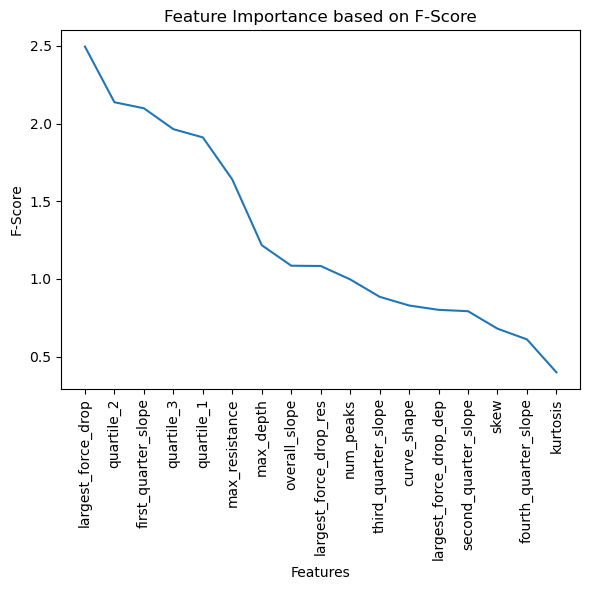

In [3]:
from sklearn.feature_selection import SelectKBest, f_classif

X = labeled_num_features.to_numpy()
y = labeled_data[f'{ylabel_name}_nums'].to_numpy()
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)
scores = selector.scores_

# display results
feature_scores = pd.DataFrame({'Feature': labeled_num_features.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print(feature_scores) 

Fig = plt.figure(figsize=(6, 6))
plt.plot(feature_scores['Feature'], feature_scores['Score'])
plt.xlabel('Features')
plt.ylabel('F-Score')  
plt.title('Feature Importance based on F-Score')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

# Create a list of features sorted based on F-Score & no two features having corr > corr_thresh

In [4]:
corr = labeled_num_features.corr()
print(corr)

corr_thresh = 0.7
optimal_features = []
add_feature_flag = 1
for feature in feature_scores['Feature']:
    above_thresh_mask = corr[feature].copy().abs() > corr_thresh
    if above_thresh_mask.sum():
        high_corr_features = corr[above_thresh_mask].index.tolist()

        for high_corr_feature in high_corr_features: 
            if high_corr_feature in optimal_features:
                add_feature_flag = 0

        if add_feature_flag:
            optimal_features.append(feature)
    add_feature_flag = 1

print(corr[optimal_features])
print(optimal_features)

                        overall_slope  max_depth  max_resistance  num_peaks  \
overall_slope                1.000000  -0.740864        0.674345  -0.423812   
max_depth                   -0.740864   1.000000       -0.928658   0.498224   
max_resistance               0.674345  -0.928658        1.000000  -0.578190   
num_peaks                   -0.423812   0.498224       -0.578190   1.000000   
largest_force_drop          -0.413119   0.325490       -0.295668   0.569359   
largest_force_drop_dep      -0.312063   0.246199       -0.235174  -0.060777   
largest_force_drop_res       0.393220  -0.453647        0.494018  -0.362288   
curve_shape                  0.019496   0.059288       -0.046934  -0.021390   
first_quarter_slope          0.891971  -0.657627        0.602814  -0.397114   
second_quarter_slope         0.910067  -0.563233        0.466531  -0.420369   
third_quarter_slope          0.873287  -0.650682        0.595295  -0.351655   
fourth_quarter_slope         0.786536  -0.712582    